# Основаная информация

Проект - оценка уровня англоязычных фильмов

Задача: по предоставленным фильмам обучить модель, которая будет предсказывать уровень английского языка, которого будет достаточно для того, чтобы смотреть данный фильм.

Предоставлено 86 фильмов и файлы с субтитрами для них.

Метрика оценки - roc-auc.

In [1]:
#!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import RegexpTokenizer

import pysubs2

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

import os
import difflib


from hyperopt import hp, fmin, tpe, Trials, STATUS_OK 
from lightgbm import LGBMClassifier
from hyperopt.pyll.base import scope
from functools import partial

from xgboost import XGBClassifier
from sklearn.svm import SVC

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nikit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# EDA 

### Основной датафрейм

---

In [3]:
df = pd.read_csv('C:/Users/nikit/Yandex/data/labels.csv')

In [181]:
# функция, которая удаляет слова, которые описывают действия в субтитрах 
# также слегка предобрабатывает текст
def delete_upper(df: dict) -> list:
    documents = []
    text = df['Text']
    
    for string in range(len(text)):
        document = re.sub('\[.+\]', '', text[string])
    
        document = re.sub('\(.+\)', '', document)

        document = re.sub(r"\'d", ' would', document)

        document = re.sub(r"\'n", ' not', document)
        if "can't" in document:
            document = re.sub(r"n\'t", 'n not', document)

        document = re.sub(r"n\'t", ' not', document)

        document = re.sub(r"\'re", ' are', document)

        document = re.sub(r"\'m", ' am', document)

        document = re.sub(r"\'s", ' is', document)

        document = re.sub(r"\'ll", ' will', document)

        document = re.sub(r"\'ve", ' have', document)

        document = re.sub(r"\\n", ' ', document)
        
        documents.append(document)
    
    
    new_documents = []
    for i in range(len(documents)):
        # прохожу по списку предложений и вытаскиваю слова
        words_list = re.findall('[A-Za-z]+', documents[i])
        new_words = ''
        for index in range(len(words_list)):
           # по списку слов просматриваю, слово с верхним регистром или нет, если нет, то добавляю его обратно, 
        #если да, то пропускаю
            word = str(words_list[index])
            if word != word.upper():
                new_words += word + ' '
        new_documents.append(new_words)
    return new_documents

# функция для того, чтобы распаковать субтитры в 1 ячейку

def text_unpacking(df: dict) -> list:
    subs_new = pysubs2.load('C:/Users/nikit/Yandex/data/Subtitles/' + df['File'], keep_unknown_html_tags=True)
    string_subtitles = []
    
    for line in subs_new:
            text = line.plaintext
            text = re.sub('(<[^<]+?>|\\n)', ' ', text)
#             if text
            
            string_subtitles.append(text)
        
    return string_subtitles



# функция лемматизации

def lemmatizer_word(df: dict) -> list:
    documents_new = []
    stemmer = WordNetLemmatizer()

    for sen in range(0, len(df['Text_new'])):
        
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(df['Text_new'][sen]))
        
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)


        # Converting to Lowercase
        document = document.lower()

#         # Lemmatization
        document = document.split()
        
        if document != []:  
        
            document = ' '.join(document)

            documents_new.append(document)
        
    return documents_new


Ниже я открываю делаю переменную со списком всех файлов с фильмами, а также нахожу сериалы, чтобы их удалить

In [6]:
# собираю названия файлов с субтитрами
subs_file_list = os.listdir('C:/Users/nikit/Yandex/data/Subtitles/')
subs_file_list.pop(0)
# делаю список сериалов, чтобы удалить их
list_series = []
for i in df['Movie'].unique():
    if '(series)' in i:
        list_series.append(i)

In [7]:
# удаляю сериалы
df = df.drop(df.query('Movie in @list_series').index) ### <<<<<< Здорово <<<<<<<
# заменяю различные знаки. Создал новый столбец, чтобы по нему искать нужный файл, а основной оставался таким каким есть.
# сделано для того, чтобы название Harry Poter (1) осталось и файл был правильно найден, с (1) файл находится неккоректно
df['Movie_new'] = df['Movie'].replace(['\n', " \(1\)", ' 🎙️', ' 😭'], '', regex=True)
df['Movie'] = df['Movie'].replace(['\n', ' 🎙️', ' 😭'], '', regex=True)


Ниже добавляю к каждому фильму нужный файл с субтитрами

In [8]:
# считываю файлы субтитров
df['File'] = df['Movie_new'].apply(lambda x: difflib.get_close_matches(x, subs_file_list, cutoff=0)[0])

С помощью text_unpacking считываю каждый файл с субтитрами построчно и добавляю в столбец с текстом субтитры.

Принимаю на вход строчку датафрейма, беру столбец файла, открываю его и получаю новый столбец с текстом.

In [9]:
df['Text'] = df.apply(text_unpacking, axis=1)

df = df[['Movie', 'Kinopoisk ', 'Level', 'Subtitles', 'Text']]

In [10]:
df

,Movie,Kinopoisk,Level,Subtitles,Text
0,Forrest Gump,Rus sub,"A2/A2+, B1",Yes,"[Hello., My name's Forrest. Forrest Gump., Do ..."
1,Finding Nemo,Everything,A2/A2+,Yes,"[[Music playing], Advertise your product or br..."
2,Cast away,"Paid, Rus sub",A2/A2+,Yes,[Created and Encoded by -- Bokutox -- of www...
3,The invisible man (2020),"Paid, Rus lan",A2/A2+,Yes,"[Adrian?, Come on., Zeus, I'm sorry. I can't t..."
4,Back to the future,Rus sub,A2/A2+,Yes,"[October is inventory time,, so right now, Sta..."
...,...,...,...,...,...
82,Mary Poppins Returns,NaN,B1,Yes,"[When the early morning hours, Have come and g..."
84,The fault in our stars,NaN,"A2/A2+, B1",Yes,[I believe we have a choice in this world abou...
85,10 Cloverfield Lane,NaN,B1,Yes,"[ Fixed & Synced by bozxphd. Enjoy The Flick ,..."
86,Lion,NaN,"B1, B2",Yes,"[Saroo., Saroo!, Come on, come on!, Get up!, C..."


In [11]:
df['Text_new'] = df.apply(delete_upper, axis=1)


In [12]:
df['Text_lemmatizer'] = df.apply(lemmatizer_word, axis=1)

df = df.reset_index(drop=True)

In [13]:
# перевожу все в 1 строчку для того, чтобы искать слова по уровням владения языка
def one_string(df):
    text_full = ''
    for text in df['Text_new']:
        text_full += text + ' '
    
    text_full = text_full.lower()
        
    return text_full

In [14]:
df['Text_string'] = df.apply(one_string, axis=1)

In [15]:
df

,Movie,Kinopoisk,Level,Subtitles,Text,Text_new,Text_lemmatizer,Text_string
0,Forrest Gump,Rus sub,"A2/A2+, B1",Yes,"[Hello., My name's Forrest. Forrest Gump., Do ...","[Hello , My name is Forrest Forrest Gump , Do ...","[hello, my name is forrest forrest gump, do yo...",hello my name is forrest forrest gump do you...
1,Finding Nemo,Everything,A2/A2+,Yes,"[[Music playing], Advertise your product or br...","[, Advertise your product or brand here contac...",[advertise your product or brand here contact ...,advertise your product or brand here contact ...
2,Cast away,"Paid, Rus sub",A2/A2+,Yes,[Created and Encoded by -- Bokutox -- of www...,[Created and Encoded by Bokutox of www com The...,[created and encoded by bokutox of www com the...,created and encoded by bokutox of www com the ...
3,The invisible man (2020),"Paid, Rus lan",A2/A2+,Yes,"[Adrian?, Come on., Zeus, I'm sorry. I can't t...","[Adrian , Come on , Zeus am sorry can not take...","[adrian, come on, zeus am sorry can not take y...",adrian come on zeus am sorry can not take yo...
4,Back to the future,Rus sub,A2/A2+,Yes,"[October is inventory time,, so right now, Sta...","[October is inventory time , so right now Stat...","[october is inventory time, so right now statl...",october is inventory time so right now statle...
...,...,...,...,...,...,...,...,...
81,Mary Poppins Returns,NaN,B1,Yes,"[When the early morning hours, Have come and g...","[When the early morning hours , Have come and ...","[when the early morning hours, have come and g...",when the early morning hours have come and go...
82,The fault in our stars,NaN,"A2/A2+, B1",Yes,[I believe we have a choice in this world abou...,[believe we have a choice in this world about ...,[believe we have choice in this world about ho...,believe we have a choice in this world about h...
83,10 Cloverfield Lane,NaN,B1,Yes,"[ Fixed & Synced by bozxphd. Enjoy The Flick ,...","[Fixed Synced by bozxphd Enjoy The Flick , , ,...","[fixed synced by bozxphd enjoy the flick, mich...",fixed synced by bozxphd enjoy the flick m...
84,Lion,NaN,"B1, B2",Yes,"[Saroo., Saroo!, Come on, come on!, Get up!, C...","[Saroo , Saroo , Come on come on , Get up , Co...","[saroo, saroo, come on come on, get up, come o...",saroo saroo come on come on get up come on...


---

### Сделать количество времени произношения предложения + количество слов в предложении

Какой план действий? 

Хотелось бы предсказывать не только на субтитрах, но и других фичах, чтобы модель лучше распозновала уровень. Для этого я собираюсь сделать новый фичи, которые будут показывать количество времени произношения предложения, также количество слов в предложении и время произношения одного слова.

Также с помощью этого можно проверить насколько правильно расставлен таргет. 

Есть ещё идея на счет того, чтобы были фичи, которые показывают количество уникальных слов разного уровня в субтитрах, что внесет нереальных вклад в предсказание, потому что это количество слов покажет представление о субтитрах.

In [16]:
count_time_df = df[['Movie', 'Level']].copy()

In [17]:
count_time_df

,Movie,Level
0,Forrest Gump,"A2/A2+, B1"
1,Finding Nemo,A2/A2+
2,Cast away,A2/A2+
3,The invisible man (2020),A2/A2+
4,Back to the future,A2/A2+
...,...,...
81,Mary Poppins Returns,B1
82,The fault in our stars,"A2/A2+, B1"
83,10 Cloverfield Lane,B1
84,Lion,"B1, B2"


In [18]:
count_time_df['Movie_new'] = count_time_df['Movie'].replace(['\n', " \(1\)", ' 🎙️', ' 😭'], '', regex=True)
count_time_df['Movie'] = count_time_df['Movie'].replace(['\n', ' 🎙️', ' 😭'], '', regex=True)

In [19]:
count_time_df['File'] = count_time_df['Movie_new'].apply(lambda x: difflib.get_close_matches(x, subs_file_list, cutoff=0)[0])

In [20]:
count_time_df = count_time_df[['Movie', 'Level', 'File']]

In [21]:
count_time_df

,Movie,Level,File
0,Forrest Gump,"A2/A2+, B1",Forrest_Gump(1994).srt
1,Finding Nemo,A2/A2+,Finding_Nemo(2003).srt
2,Cast away,A2/A2+,Cast_away(2000).srt
3,The invisible man (2020),A2/A2+,The_invisible_man(2020).srt
4,Back to the future,A2/A2+,Back_to_the_future(1985).srt
...,...,...,...
81,Mary Poppins Returns,B1,Mary_Poppins_returns(2018).srt
82,The fault in our stars,"A2/A2+, B1",The_fault_in_our_stars(2014).srt
83,10 Cloverfield Lane,B1,10_Cloverfield_lane(2016).srt
84,Lion,"B1, B2",Lion(2016).srt


In [22]:
# с помощью цикла соединяю все фильмы с субтитрами вместе
# создаю первую строчку датафрейма для соединения
df_full = pd.DataFrame({'Movie': 'Forrest Gump', 'Level': 'A2/A2+, B1', 'Text': 'Hello.'}, index=[0])

for index in count_time_df.index:
    subs = pysubs2.load('C:/Users/nikit/Yandex/data/Subtitles/' + count_time_df.loc[index, 'File'])
    start_time = []
    stop_time = []
    text_list = []
    level = count_time_df.loc[index, 'Level']

    for line in subs:
        start_time.append(line.start) # Время начала субтитра
        stop_time.append(line.end) # Время окончания субтитра
        # Время в миллисекундах 

        text_list.append(line.plaintext) # Текст без тегов
        
    df_new = pd.DataFrame({'Start': start_time, 'Stop': stop_time, 'Text': text_list, 'Level': level})
    df_new['Movie'] = count_time_df.loc[index, 'Movie']
    df_full = df_full.merge(df_new, how='outer')

In [23]:
df_full

,Movie,Level,Text,Start,Stop
0,Forrest Gump,"A2/A2+, B1",Hello.,199349,200599
1,Forrest Gump,"A2/A2+, B1",My name's Forrest. Forrest Gump.,201559,204228
2,Forrest Gump,"A2/A2+, B1",Do you want a chocolate?,209776,211819
3,Forrest Gump,"A2/A2+, B1",I could eat about\na million and a half of these.,214405,217825
4,Forrest Gump,"A2/A2+, B1",My mama always said\nlife was like a box of ch...,218993,224206
...,...,...,...,...,...
130643,House of Gucci,B2,[Tracy] ♪ You'd be mine ♪,9136070,9137905
130644,House of Gucci,B2,[Pavarotti singing in Italian],9139007,9141208
130645,House of Gucci,B2,- [Tracy] ♪ You'd be mine ♪\n- [Pavarotti sing...,9143077,9146814
130646,House of Gucci,B2,[audience cheering],9147515,9149651


In [26]:
# функция для предобработки текста
def preproccesing(df):
    text = df['Text']
    
    text = re.sub('\[.+\]', '', text)
    
    text = re.sub('\(.+\)', '', text)
    
    text = re.sub(r"\'d", ' would', text)
        
    text = re.sub(r"\'n", ' not', text)
    if "can't" in text:
        text = re.sub(r"n\'t", 'n not', text)
        
    text = re.sub(r"n\'t", ' not', text)

    text = re.sub(r"\'re", ' are', text)

    text = re.sub(r"\'m", ' am', text)

    text = re.sub(r"\'s", ' is', text)

    text = re.sub(r"\'ll", ' will', text)

    text = re.sub(r"\'ve", ' have', text)

    text = re.sub(r"\\n", ' ', text)
    
    words_list = re.findall('[A-Za-z]+', text)
    new_words = ''
    for index in range(len(words_list)):
        word = str(words_list[index])
        if word != word.upper() or word == 'I':
            new_words += word + ' '
    return new_words

In [27]:
df_full['Test'] = df_full.apply(preproccesing, axis=1)

Остаются строки, где текста нет, их я удалю(это строчки с действием и т.д.)

In [28]:
df_full[df_full['Movie'] == '10 Cloverfield Lane']

,Movie,Level,Text,Start,Stop,Test
126539,10 Cloverfield Lane,B1,Fixed & Synced by bozxphd. Enjoy The Flick,55279,67279,Fixed Synced by bozxphd Enjoy The Flick
126540,10 Cloverfield Lane,B1,(CLANGING),71280,72838,
126541,10 Cloverfield Lane,B1,(DRAWER CLOSES),76480,77833,
126542,10 Cloverfield Lane,B1,(INAUDIBLE),115800,117597,
126543,10 Cloverfield Lane,B1,(CELL PHONE RINGING),247800,249313,
...,...,...,...,...,...,...
127598,10 Cloverfield Lane,B1,And we 're winning.,5815520,5816839,And we are winning
127599,10 Cloverfield Lane,B1,But if you have any medical trainingor combat ...,5817360,5820636,But if you have any medical trainingor combat ...
127600,10 Cloverfield Lane,B1,there are survivors...,5821440,5823112,there are survivors
127601,10 Cloverfield Lane,B1,(TIRES SQUEALING),5828560,5830357,


In [29]:
index_drop = df_full[df_full['Test'] == ''].index

In [30]:
df_full = df_full.drop(index_drop)

In [31]:
# создаю новые фичи
df_full['time_pronunciation'] = df_full['Stop'] - df_full['Start']
df_full['length'] = df_full['Test'].apply(lambda x: len(re.findall('[A-Za-z]+', x)))
df_full['pronunciation_speed'] = df_full['time_pronunciation'] / df_full['length']

In [32]:
df_full

,Movie,Level,Text,Start,Stop,Test,time_pronunciation,length,pronunciation_speed
0,Forrest Gump,"A2/A2+, B1",Hello.,199349,200599,Hello,1250,1,1250.000000
1,Forrest Gump,"A2/A2+, B1",My name's Forrest. Forrest Gump.,201559,204228,My name is Forrest Forrest Gump,2669,6,444.833333
2,Forrest Gump,"A2/A2+, B1",Do you want a chocolate?,209776,211819,Do you want a chocolate,2043,5,408.600000
3,Forrest Gump,"A2/A2+, B1",I could eat about\na million and a half of these.,214405,217825,I could eat about a million and a half of these,3420,11,310.909091
4,Forrest Gump,"A2/A2+, B1",My mama always said\nlife was like a box of ch...,218993,224206,My mama always said life was like a box of cho...,5213,11,473.909091
...,...,...,...,...,...,...,...,...,...
130639,House of Gucci,B2,[Tracy] ♪ Maybe if I told\nyou The right words ♪,9120755,9124792,Maybe if I told you The right words,4037,8,504.625000
130640,House of Gucci,B2,"♪ Ooh, at the right time ♪",9126326,9128796,Ooh at the right time,2470,5,494.000000
130641,House of Gucci,B2,♪ You'd be mine ♪,9129831,9131866,You would be mine,2035,4,508.750000
130643,House of Gucci,B2,[Tracy] ♪ You'd be mine ♪,9136070,9137905,You would be mine,1835,4,458.750000


In [33]:
df_full_concat = df_full.groupby(['Movie', 'Level'], as_index=False)[['time_pronunciation',
                                                                      'length', 
                                                                      'pronunciation_speed']].mean()

In [34]:
df_full_concat

,Movie,Level,time_pronunciation,length,pronunciation_speed
0,10 Cloverfield Lane,B1,2074.896797,5.920522,458.784453
1,10 things I hate about you,B1,2433.980640,7.402357,418.785238
2,A knight’s tale,B2,2501.513158,6.213816,508.333175
3,A star is born,B2,2324.552350,6.456026,458.814558
4,Aladdin,A2/A2+,2777.040030,6.181616,626.228691
...,...,...,...,...,...
81,Twilight,A2/A2+,2252.778477,5.536920,563.965515
82,Up,A2/A2+,2502.732240,6.692896,476.196384
83,Venom,B2,2250.889706,6.325000,514.689715
84,Warm bodies,B1,1860.318729,5.381161,491.611602


In [176]:
sort_df_stat = df_full_concat.groupby('Level')[['time_pronunciation', 'length', 'pronunciation_speed']].mean()

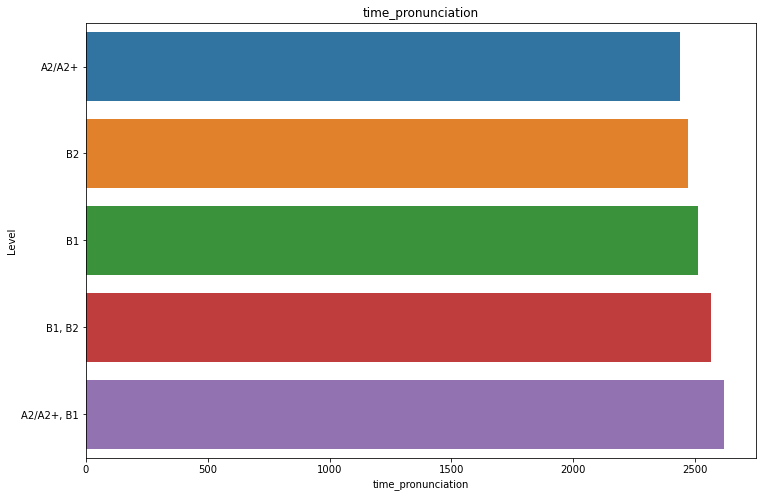

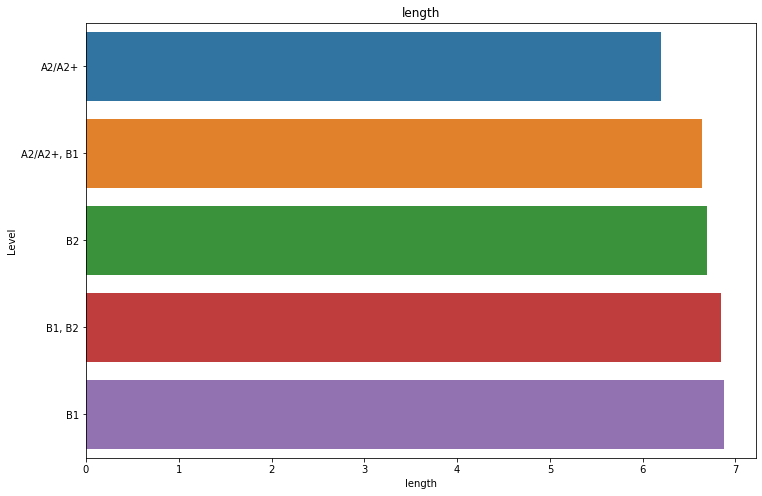

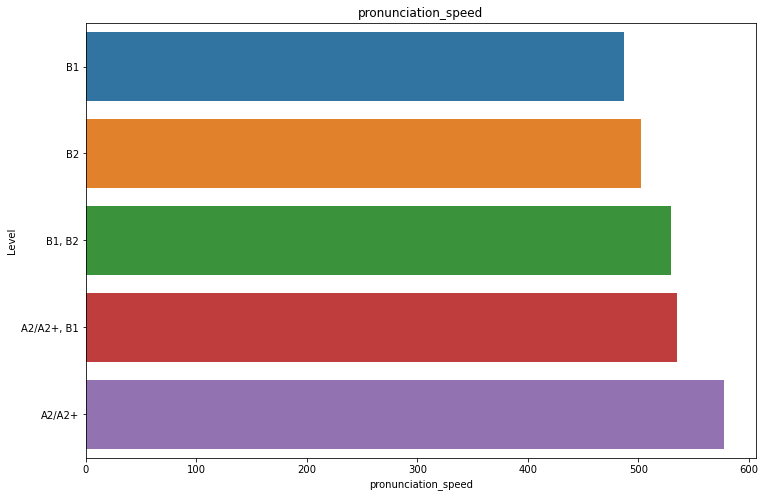

In [177]:
for column in sort_df_stat.columns:
    df = sort_df_stat.sort_values(by=column)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data=df,x=column,y=df[column].index)
    ax.set_title(column)
    plt.xlabel(column)

Удивительно, конечно, но субтитры слегка показывают правду, но не везде... 

**Прошлый вывод**

Графики: по длине предложения все хорошо, чем выше уровень, тем длиннее предложение, на счет времени произношения предложения... График показывает не самую лучшую информацию из-за того, что предложение на уровне выше будет говориться либо также, как на уровне ниже, либо дольше только из-за того, что оно само по себе длиннее, для этого и вводилась новая фича, которая показывает как быстро произносится 1 слово. На графике с произношением слова видно, что очень большой разброс, следовательно, я могу предполагать, что таргеты могут быть расставлены неправильно.

---

**Новый вывод**

Спустя время понял, что все таки по субтитрам пытаться понять скорость произношения слова - плохая идея. Все таки субтитры не передают этого, они сделаны для того, чтобы прочитать и понять то, что сложно воспринимать на слух, следовательно, они показываются дольше, чем говорит актер. А также субтитры для каждого уровня показываются почти одинаково...

Также могу сказать, что количество слов в предложении можно намного лучше предобработать, т.к. получается так, что в 1 строке субтитра может быть 1 предложение, а у меня получается так, что эти несколько предложений являются 1.

**Вывод** : Думаю, что данные фичи не сильно помогают + имеется шум в таргете, который все таки расставить самому не получится, а достоверные таргеты не предоставили.

Что в итоге? 

Что можно было сделать и сделано: предобработать субтитры, а также найти количество слов/фраз в каждом субтитре каждого уровня с помощью предобработанного словаря со словами каждых уровней. Что и будет сделано ниже.

### Слова с level English

---


Идеи


Хотелось бы по одному словарю найти количество слов/фраз разных уровней, которые встречаются в субтитрах. Это должно дать большее понимание. Во фразах есть некоторые тонкости, которые нужно убрать, по типу etc. слова через /. Этим я и буду заниматься ниже

In [39]:
df_words = pd.read_json('C:/Users/nikit/Documents/GitHub/englishprofile-scraper/englishprofile.json')

In [40]:
df_words

,baseword,guideword,level,partofspeech,topic,url
0,cattle,None,B1,None,animals,/british-english/words/detail/817
1,clothes,None,A1,None,clothes,/british-english/words/detail/972
2,albeit,None,C2,None,None,/british-english/words/detail/157
3,and,ALSO,A1,None,communication,/british-english/words/detail/229
4,and,AFTER,A1,None,communication,/british-english/words/detail/229
...,...,...,...,...,...,...
15691,with your bare hands,IDIOM,C2,phrase,None,/british-english/words/detail/6692
15692,with bated breath,IDIOM,C2,phrase,None,/british-english/words/detail/6692
15693,be lost for words,IDIOM,C2,phrase,None,/british-english/words/detail/6709
15694,not be the end of the world,IDIOM,C2,phrase,None,/british-english/words/detail/6720


In [41]:
# удаляю дубликаты, т.к. они будут мешать
df_words = df_words.drop_duplicates(subset='baseword')

In [47]:
def words_level(text_list:dict) -> dict:
    words_list_new = []
    for string in text_list:
        
        string = string.lower()

        string = string.replace(r"sth/sb", '[a-z]+')
        string = string.replace(r"sb/sth", '[a-z]+')
        string = string.replace(r"sth", '[a-z]+')
        string = string.replace(r"sb's", '[a-z]+')
        string = string.replace(r"sb", '[a-z]+')
        string = re.sub(r'\(', '(?:', string)
        string = re.sub(r'\)', ')?', string)

        if 'etc' in string:

            string = re.sub('[A-Za-z]+\/[A-Za-z]+[\/[A-Za-z]+]?', '[a-z]+', string)

            string = string.replace('/', '|')

            string = re.sub(r', etc.', '', string)

            words_list_new.append(string)

        else:
            if '/' in string:
                # нахожу слова с /
                change = re.findall('[A-Za-z]+\/[A-Za-z]+[\/[A-Za-z]+]?', string)
                for i in range(len(change)):
                    # делаю переменную со словом, которое меняется 
                    slash_word = re.split('/', change[i])
                    change_new = change[i]

                    for word in range(len(slash_word)):
                        # заменяю те слова через / на каждое слово, и добавляю в новый список
                        change_word = slash_word[word]
                        new_word = re.sub(change_new, change_word, string)
                        words_list_new.append(new_word)
            else:
                words_list_new.append(string)
                    
    return words_list_new
                
        

In [51]:
A1 = words_level(df_words[df_words['level'] == 'A1']['baseword'].values)
A2 = words_level(df_words[df_words['level'] == 'A2']['baseword'].values)
B1 = words_level(df_words[df_words['level'] == 'B1']['baseword'].values)
B2 = words_level(df_words[df_words['level'] == 'B2']['baseword'].values)
C1 = words_level(df_words[df_words['level'] == 'C1']['baseword'].values)
C2 = words_level(df_words[df_words['level'] == 'C2']['baseword'].values)

In [52]:
# функция подсчета слов/фраз
def new_features_words(df, level_list_string):
    count = 0
    for word in level_list_string:
        if len(re.findall(word, df['Text_string'])) > 0:
            count += 1
    return count

In [53]:
df = df[['Movie', 'Level','Text_lemmatizer', 'Text_string']]

In [54]:
level_list = {'A1':A1, 'A2':A2, 'B1':B1, 'B2':B2, 'C1':C1, 'C2':C2}

for level, level_l in level_list.items():
    df[level] = df.apply(new_features_words, level_list_string=level_l, axis=1)

In [182]:
# функция для нормирования по каждому лвл'у, т.е. какой процент этих слов содержится в уникальных значениях фильма.
def normalize_level_word(df: pd.DataFrame) -> pd.DataFrame:
    df_new = pd.DataFrame(re.findall('[a-z]+', df['Text_string']))
    df_new.columns = ['Word']
    df_new = df_new.drop(df_new[df_new['Word'].duplicated()].index)
    df['A1_norm'] = df['A1'] / len(df_new['Word'].values) * 100
    df['A2_norm'] = df['A2'] / len(df_new['Word'].values) * 100
    df['B1_norm'] = df['B1'] / len(df_new['Word'].values) * 100
    df['B2_norm'] = df['B2'] / len(df_new['Word'].values) * 100
    df['C1_norm'] = df['C1'] / len(df_new['Word'].values) * 100
    df['C2_norm'] = df['C2'] / len(df_new['Word'].values) * 100
    
    return df
    

In [56]:
df = df.apply(normalize_level_word, axis=1)

In [57]:
df

,Movie,Level,Text_lemmatizer,Text_string,A1,A2,B1,B2,C1,C2,A1_norm,A2_norm,B1_norm,B2_norm,C1_norm,C2_norm
0,Forrest Gump,"A2/A2+, B1","[hello, my name is forrest forrest gump, do yo...",hello my name is forrest forrest gump do you...,296,354,395,308,86,137,18.698673,22.362603,24.952622,19.456728,5.432723,8.654454
1,Finding Nemo,A2/A2+,[advertise your product or brand here contact ...,advertise your product or brand here contact ...,246,284,368,287,103,132,16.895604,19.505495,25.274725,19.711538,7.074176,9.065934
2,Cast away,A2/A2+,[created and encoded by bokutox of www com the...,created and encoded by bokutox of www com the ...,242,256,285,197,74,95,23.426912,24.782188,27.589545,19.070668,7.163601,9.196515
3,The invisible man (2020),A2/A2+,"[adrian, come on, zeus am sorry can not take y...",adrian come on zeus am sorry can not take yo...,233,231,291,215,68,92,24.866596,24.653148,31.056564,22.945571,7.257204,9.818570
4,Back to the future,A2/A2+,"[october is inventory time, so right now statl...",october is inventory time so right now statle...,267,329,413,341,109,131,18.350515,22.611684,28.384880,23.436426,7.491409,9.003436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,Mary Poppins Returns,B1,"[when the early morning hours, have come and g...",when the early morning hours have come and go...,303,391,459,401,118,175,16.351862,21.100917,24.770642,21.640583,6.368052,9.444145
82,The fault in our stars,"A2/A2+, B1",[believe we have choice in this world about ho...,believe we have a choice in this world about h...,283,352,455,395,133,176,16.607981,20.657277,26.701878,23.180751,7.805164,10.328638
83,10 Cloverfield Lane,B1,"[fixed synced by bozxphd enjoy the flick, mich...",fixed synced by bozxphd enjoy the flick m...,228,242,308,223,66,96,22.331048,23.702253,30.166503,21.841332,6.464251,9.402547
84,Lion,"B1, B2","[saroo, saroo, come on come on, get up, come o...",saroo saroo come on come on get up come on...,217,213,208,136,53,63,29.127517,28.590604,27.919463,18.255034,7.114094,8.456376


In [58]:
mean_word_level = df.groupby('Level')[['A1', 'A2', 'B1','B2', 'C1', 'C2']].mean()

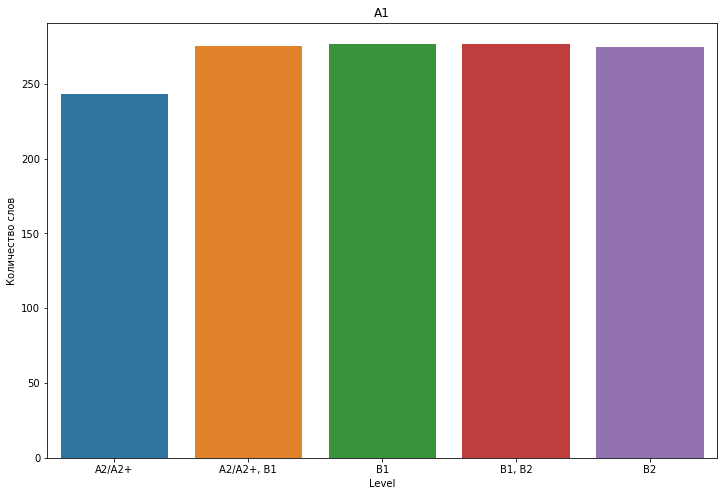

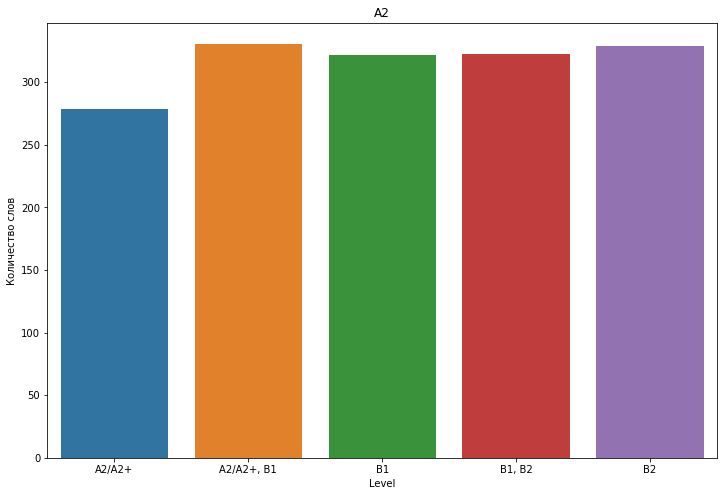

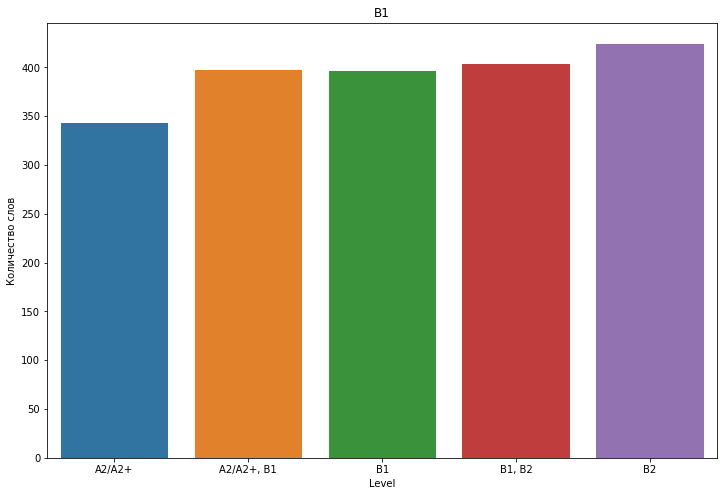

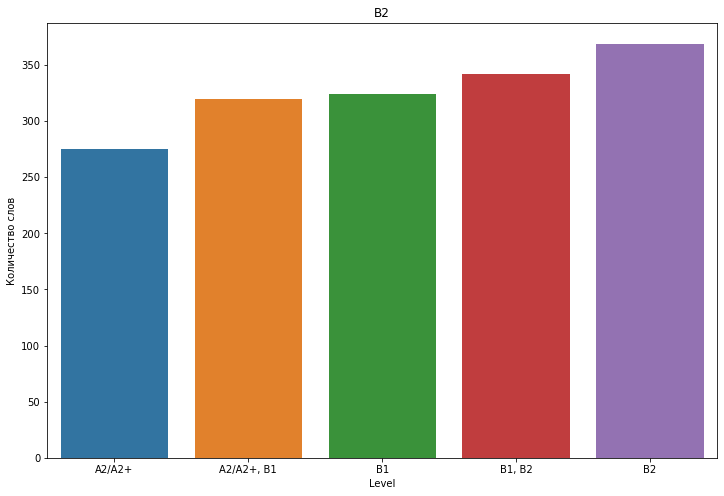

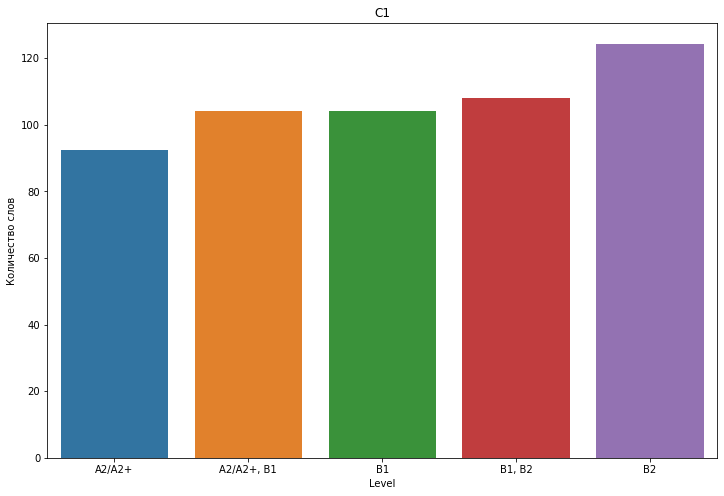

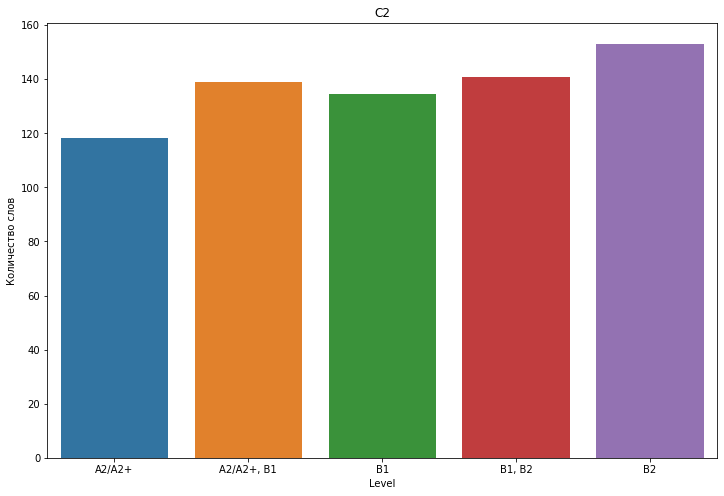

In [59]:
for level in level_list:
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data=mean_word_level,x=mean_word_level.index,y=level)
    ax.set_title(level)
    plt.ylabel('Количество слов')

Графики интересные и показывают, что в каждом фильме чем выше уровень владения языком, тем больше слов разных уровней.

In [64]:
df = df[['Movie', 'Level', 'Text_lemmatizer','A1_norm', 'A2_norm', 'B1_norm', 'B2_norm', 'C1_norm', 'C2_norm']]

In [65]:
df

,Movie,Level,Text_lemmatizer,A1_norm,A2_norm,B1_norm,B2_norm,C1_norm,C2_norm
0,Forrest Gump,"A2/A2+, B1","[hello, my name is forrest forrest gump, do yo...",18.698673,22.362603,24.952622,19.456728,5.432723,8.654454
1,Finding Nemo,A2/A2+,[advertise your product or brand here contact ...,16.895604,19.505495,25.274725,19.711538,7.074176,9.065934
2,Cast away,A2/A2+,[created and encoded by bokutox of www com the...,23.426912,24.782188,27.589545,19.070668,7.163601,9.196515
3,The invisible man (2020),A2/A2+,"[adrian, come on, zeus am sorry can not take y...",24.866596,24.653148,31.056564,22.945571,7.257204,9.818570
4,Back to the future,A2/A2+,"[october is inventory time, so right now statl...",18.350515,22.611684,28.384880,23.436426,7.491409,9.003436
...,...,...,...,...,...,...,...,...,...
81,Mary Poppins Returns,B1,"[when the early morning hours, have come and g...",16.351862,21.100917,24.770642,21.640583,6.368052,9.444145
82,The fault in our stars,"A2/A2+, B1",[believe we have choice in this world about ho...,16.607981,20.657277,26.701878,23.180751,7.805164,10.328638
83,10 Cloverfield Lane,B1,"[fixed synced by bozxphd enjoy the flick, mich...",22.331048,23.702253,30.166503,21.841332,6.464251,9.402547
84,Lion,"B1, B2","[saroo, saroo, come on come on, get up, come o...",29.127517,28.590604,27.919463,18.255034,7.114094,8.456376


---

### Baseline

---

Попробую 2 способа предобработки: CountVectorizer, а также TF-IDF. Найду лучшие модели.

### CountVectorizer

In [67]:
data = df_full_concat.merge(df)

In [68]:
data

,Movie,Level,time_pronunciation,length,pronunciation_speed,Text_lemmatizer,A1_norm,A2_norm,B1_norm,B2_norm,C1_norm,C2_norm
0,10 Cloverfield Lane,B1,2074.896797,5.920522,458.784453,"[fixed synced by bozxphd enjoy the flick, mich...",22.331048,23.702253,30.166503,21.841332,6.464251,9.402547
1,10 things I hate about you,B1,2433.980640,7.402357,418.785238,"[hey, will be right with you, so cameron here ...",16.817594,19.275550,25.808538,21.604140,6.985770,9.702458
2,A knight’s tale,B2,2501.513158,6.213816,508.333175,"[resync xenzai, should we help him, he is due ...",16.915761,17.595109,24.660326,20.380435,7.336957,9.646739
3,A star is born,B2,2324.552350,6.456026,458.814558,"[synced and corrected by mrcjnthn, get to it, ...",20.119225,22.652757,27.645306,19.970194,7.004471,7.600596
4,Aladdin,A2/A2+,2777.040030,6.181616,626.228691,"[oh come from land from faraway place, where t...",16.488652,19.893191,24.899866,21.161549,7.943925,9.612817
...,...,...,...,...,...,...,...,...,...,...,...,...
81,Twilight,A2/A2+,2252.778477,5.536920,563.965515,[would never given much thought to how would d...,19.571231,22.475795,27.869986,21.023513,6.915629,9.474412
82,Up,A2/A2+,2502.732240,6.692896,476.196384,[movietown news presents spotlight on adventur...,21.353251,22.407733,25.746924,20.123023,6.414763,8.875220
83,Venom,B2,2250.889706,6.325000,514.689715,"[life foundation control this is, the specimen...",18.791946,22.371365,27.665921,25.130500,9.097688,9.097688
84,Warm bodies,B1,1860.318729,5.381161,491.611602,"[what am doing with my life, am so pale should...",23.190045,24.208145,28.393665,22.171946,8.031674,8.484163


In [69]:
string_list_all = []
for i in data.index:
    string = ''
    string_list_local = []
    for words in data.loc[i, 'Text_lemmatizer']:
    
        string += words + ' '
    string_list_local.append(string)
    string_list_all.append(string_list_local)

In [70]:
data_vectorize = pd.DataFrame(string_list_all, columns=['Text'])

In [71]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(data_vectorize['Text']).toarray()

In [72]:
data_vectorize = pd.DataFrame(X, columns=vectorizer.get_feature_names())

In [73]:
data = data[['Level', 'pronunciation_speed', 'A1_norm', 'A2_norm', 'B1_norm', 'B2_norm', 'C1_norm', 'C2_norm']]

In [74]:
data_real = data_vectorize.join(data, how='outer')

In [75]:
features_test_join = data_real.drop(['Level'], axis=1)
target_join = data_real['Level']

In [76]:
encoder = OrdinalEncoder()
ordinal = encoder.fit_transform(target_join.values.reshape(-1, 1))
target_new =pd.DataFrame(ordinal)[0].astype(int)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(features_test_join, target_new, test_size=0.33, 
                                                    random_state=42, stratify=target_new)


In [78]:
scaler = MinMaxScaler()
minmax_scaler = scaler.fit(features_test_join)
features_test_join = minmax_scaler.transform(features_test_join)

In [79]:
model = LogisticRegression(penalty='l2', max_iter=150)


print(cross_val_score(model,features_test_join,target_new,cv=5,scoring='roc_auc_ovo').mean())

0.6363944444444445


---

### TF-IDF

In [80]:
data_tfidf = pd.DataFrame(string_list_all, columns=['Text'])

In [81]:
tfidf = TfidfVectorizer(min_df=0.2, max_df=0.7, stop_words=stopwords.words('english'), ngram_range=(1,3))
X_tfidf = tfidf.fit_transform(data_tfidf['Text']).toarray()

In [82]:
data_tfidf = pd.DataFrame(X_tfidf, columns=tfidf.get_feature_names())

In [83]:
data_tfidf = data_tfidf.join(data, how='outer')

In [84]:
features_test_tfidf = data_tfidf.drop(['Level'], axis=1)
target_tfidf = data_tfidf['Level']


X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(features_test_tfidf, target_tfidf, test_size=0.33, 
                                                    random_state=42, stratify=target_new)

In [85]:
scaler = MinMaxScaler()
minmax_scaler = scaler.fit(features_test_tfidf)
features_test_tfidf = minmax_scaler.transform(features_test_tfidf)

In [86]:
model = LogisticRegression(penalty='l2', max_iter=150)


print(cross_val_score(model,features_test_tfidf,target_tfidf,cv=5,scoring='roc_auc_ovo').mean())

0.579988888888889


**Прошлые выводы**

---

Пока что хорошо предскывает A2/A2+ и B2

После добавления фичей, уже потихоньку учимся предсказывать B1. Как бы выделить А2 и т.д., могут ли помочь количество слов для каждого уровня? Думаю, что да, нужно попробовать

**Baseline** Прошлый 0.31(предобработанные субтитры), после добавления новых фичей(скорость произношения предложения, длина предложения, скорость произношения слова в предложении) score поднялся до 0.448, неплохо, думаю. После добавления фичей с количеством уникальных слов каждого уровня в субтитре score повысился до 0.51. Я думаю, что таргеты расставлены чутка неккоректно, т.к. количество уникальных слов каждого уровня и графики скорости произношения слова в предложения показывают чуть другую картиру. На счет слов из уровня С1 и С2, возможно, после предобработки был убрат где-то смысл и из-за этого с уровнях ниже, чем С2 встречаются слова С2 больше, чем в С2 :) Но также считаю, что условия равные у каждого субтитра, список со словами каждому субтитру дается одинаковый.

Также есть вариант того, что можно будет предсказывать вероятность того, что он относится к какому-то уровню владением языка.

**Модели:** пока что была использована обычная логистическая регрессия, можно будет использовать бустинг, думаю, что выдаст скор около 60 процентов, после чего можно будет подумать над лучшей предобработкой и расстановке тагерта.

---

**Новые выводы**

После новой предобработки лучшее качество дает LGBM, после нее идет логистическая регрессия, также удостоверился, что с маленьким количесвом данных все таки логистическая регрессия работает лучше, обучается быстрее, а также не нужно искать какие-либо параметры модели.

Лучшее качество 0.64 по кросс-валидации. Метрика оценки - roc-auc. Имеется большой дисбаланс классов, следовательно, accuracy не подходит.

## Использование других моделей

### CountVectorizer

In [87]:
seed=2

# список гиперпараметров и их значения
search_space = {
                'n_estimators':hp.uniform('n_estimators', 300, 1000),
                
                'max_depth':hp.uniform('max_depth', 20, 150),
                
                'num_leaves':hp.uniform('num_leaves', 31, 300)
                
    }

def objective(params, x, y):
    # переводим параметры в int
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    nl=int(params['num_leaves'])
    
    # задаём модели требуемые параметры    
    model=LGBMClassifier(n_estimators=est, max_depth=md, num_leaves = nl, reg_lambda = 0.01, min_split_gain=0.2)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=model, X=x, y=y, 
                            scoring='roc_auc_ovo', cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return {'loss': score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, x=features_test_join, y=target_new),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=300,
          # куда сохранять историю поиска
            trials=trials,
          # random_state  
            rstate = np.random.default_rng(seed)
        )

100%|██████████| 300/300 [03:05<00:00,  1.62trial/s, best loss: 0.45565476190476195]


In [88]:
print(best)

{'max_depth': 71.01406756770899, 'n_estimators': 705.0755478006176, 'num_leaves': 118.25878842666755}


In [89]:
LGBM = LGBMClassifier(n_estimators=424, max_depth=24, num_leaves=142, reg_lambda = 0.01,
                     min_split_gain=0.2, n_jobs = -1, random_state=42)

print(cross_val_score(LGBM,features_test_join,target_new,cv=5,scoring='roc_auc_ovo').mean())

0.6408388888888888


In [90]:
seed=2

# список гиперпараметров и их значения
search_space = {
                'n_estimators':hp.uniform('n_estimators', 25, 500),
                
                'max_depth':hp.uniform('max_depth', 1, 20),
                
                'gamma':hp.uniform('gamma', 1, 10),
                
                'learning_rate' : hp.uniform('learning_rate', 0.01, 0.1),
    
                'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1.0),
    
                
                'subsample': hp.uniform('subsample', 0.8, 1.0)
                
    
                
    }

def objective(params, x, y):
    # переводим параметры в int
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    g = params['gamma']
    lr = params['learning_rate']
    cb = params['colsample_bytree']
    s = params['subsample']
    
    
    # задаём модели требуемые параметры    
    model=XGBClassifier(n_estimators=est, max_depth=md, gamma = g, learning_rate = lr, colsample_bytree=cb, subsample=s)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=model, X=x, y=y, 
                            scoring='roc_auc_ovo', cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return {'loss': score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, x=features_test_join, y=target_new),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=300,
          # куда сохранять историю поиска
            trials=trials,
          # random_state  
            rstate = np.random.default_rng(seed)
        )

100%|██████████| 300/300 [30:04<00:00,  6.02s/trial, best loss: 0.4066687925170068]


In [91]:
print(best)

{'colsample_bytree': 0.8835513516072004, 'gamma': 8.101980598345115, 'learning_rate': 0.0833032108687157, 'max_depth': 15.59167412669855, 'n_estimators': 387.06529299996015, 'subsample': 0.974673381284929}


In [92]:
XGB = XGBClassifier(objective='multi:softprob', n_estimators=227, max_depth=9, gamma=9.025843079400055, 
                    colsample_bytree = 0.8092403481954864,
                    subsample=0.8765265142424533, learning_rate=0.03645631048789577, n_jobs = -1, random_state=42)


print(cross_val_score(XGB,features_test_join,target_new,cv=5,scoring='roc_auc_ovo').mean())

0.49095555555555553


In [93]:
seed=2

# список гиперпараметров и их значения
search_space = {
                'C':hp.uniform('C', 0.1, 20),
                
                'gamma':hp.uniform('gamma', 0.0001, 0.1)
                
    
                
    }

def objective(params, x, y):
    # переводим параметры в int
    C=params['C']
    g = params['gamma']
    
    
    # задаём модели требуемые параметры    
    model=SVC(gamma = g, C=C, probability=True)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=model, X=x, y=y, 
                            scoring='roc_auc_ovo', cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return {'loss': score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, x=features_test_join, y=target_new),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=1500,
          # куда сохранять историю поиска
            trials=trials,
          # random_state  
            rstate = np.random.default_rng(seed)
        )
print(best)

100%|██████████| 1500/1500 [01:32<00:00, 16.15trial/s, best loss: 0.3366071428571429]
{'C': 5.041075673279752, 'gamma': 0.05945541332437856}


In [94]:
SVC_model = SVC(probability=True, gamma=0.02848680802025344, C=14.264706083011111, random_state=42)

SVC_model.fit(X_train, y_train)
prediction = SVC_model.predict(X_test)
print(accuracy_score(y_test, prediction))

0.3103448275862069


### TF-IDF

In [95]:
seed=2

# список гиперпараметров и их значения
search_space = {
                'n_estimators':hp.uniform('n_estimators', 300, 1000),
                
                'max_depth':hp.uniform('max_depth', 20, 150),
                
                'num_leaves':hp.uniform('num_leaves', 31, 300)
                
    }

def objective(params, x, y):
    # переводим параметры в int
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    nl=int(params['num_leaves'])
    
    # задаём модели требуемые параметры    
    model=LGBMClassifier(n_estimators=est, max_depth=md, num_leaves = nl, reg_lambda = 0.01, min_split_gain=0.2)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=model, X=x, y=y, 
                            scoring='roc_auc_ovo', cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return {'loss': score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, x=features_test_tfidf, y=target_tfidf),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=300,
          # куда сохранять историю поиска
            trials=trials,
          # random_state  
            rstate = np.random.default_rng(seed)
        )

100%|██████████| 300/300 [04:49<00:00,  1.04trial/s, best loss: 0.4336840986394558]


In [96]:
print(best)

{'max_depth': 89.58283098086518, 'n_estimators': 734.2506200847891, 'num_leaves': 100.95686735100652}


In [97]:
LGBM = LGBMClassifier(n_estimators=734, max_depth=89, num_leaves=100, reg_lambda = 0.01,
                     min_split_gain=0.2, n_jobs = -1, random_state=42)

print(cross_val_score(LGBM,features_test_tfidf,target_tfidf,cv=5,scoring='roc_auc_ovo').mean())

0.5364166666666667


Видно, что TF-IDF дает рузультаты хуже, чем CountVectorizer.

Дальше не вижу смысла смотреть другие модели.

**Вывод**

Была проделана неплохая работа, я получил новые знания предобработки текста, а также просто познакомился с NLP. На счет проекта, лучшая модель - LGBM, roc-auc - 0.64. На счет правильности модели... Таргеты расставлены не так, как хотелось бы и из-за этого использовать данную модель есть ли смысл? Предсказываем A2, B1, B2, но у нас имеются такие таргеты как A2/A2+, B1, которые мешают модели и хотелось бы, чтобы данные таргеты были расставлены точно, иначе будет выдаваться неверный ответ.